# Big Data Application: Modeling for Crop Yield Estimation

This jupyter notebook is addressed for creating model that can estimate crop yield in North Dakota, United States. The detail workflow of this project can be seen in [here](https://drive.google.com/file/d/1u3jHTnLqoxMca7SRzgnvGjP-iBvfTnls/view?usp=sharing).

## 0. Install & Load Packages

In [78]:
#install packages
!pip install tensorflow

In [79]:
#load packages

import pandas as pd
from sklearn.preprocessing import StandardScaler

#packages for manipulating dataframe
import numpy as np
import pandas as pd
import geopandas as gpd
from shapely.geometry import Point
import sklearn

#packages for machine learning
##train-test-split
from sklearn.model_selection import train_test_split, GridSearchCV, validation_curve

##method 1: Linear Regression (LR)
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import cross_val_score

##method 2: Random Forest Regressor (RF)
import rfpimp
from sklearn.ensemble import RandomForestRegressor

##method 3: Gradient Boosting Regressor (XGB)
import xgboost
from xgboost import XGBRegressor

##method 4: Artificial Neural Network (ANN)
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

##cross validation

##evaluation metrics (R2 and RMSE)
from sklearn.metrics import r2_score, mean_squared_error

#data visualization
import matplotlib.pyplot as plt

pd.set_option('display.max_rows', 300) # specifies number of rows to show
pd.options.display.float_format = '{:40,.4f}'.format # specifies default number format to 4 decimal places
plt.style.use('ggplot') # specifies that graphs should use ggplot styling
%matplotlib inline

## 1. Load & Cleaning Data

In [131]:
#load data
soybean_2018 = pd.read_csv('https://www.dropbox.com/scl/fi/ixibqk9pyuehwvoz7mr1h/2018_County_Summary_Merged.csv?rlkey=wueodqdvzsht5or4eftwdd3ys&dl=1')
soybean_2019 = pd.read_csv('https://www.dropbox.com/scl/fi/x3oiqrikr0xagqrh5tiqu/2019_County_Summary_Merged.csv?rlkey=zr5wru8sg5iybp43lnjf7ls5a&dl=1')
soybean_2020 = pd.read_csv('https://www.dropbox.com/scl/fi/m4r74ydgw3yno93nakagl/2020_County_Summary_Merged.csv?rlkey=kmd8bozo9z9jxznoa775gg33z&dl=1')
soybean_2021 = pd.read_csv('https://www.dropbox.com/scl/fi/2vmvsyjloz9hvzejtdez4/2021_County_Summary_Merged.csv?rlkey=ossgr4x3fvzgebhqprchntt2f&dl=1')
soybean_2022 = pd.read_csv('https://www.dropbox.com/scl/fi/x61224yvwtq4idnqphwjy/2022_County_Summary_Merged.csv?rlkey=s3zm9ooap8pjqom3jr0aklc6t&dl=1')
soybean_2023 = pd.read_csv('https://www.dropbox.com/scl/fi/zrjnmeqysrokfsua24hb3/2023_County_Summary_Merged.csv?rlkey=jb4w1pt295zeagbvgm7c2t7pk&dl=1')

In [132]:
soybean_list = [soybean_2018, soybean_2019, soybean_2020, soybean_2021, soybean_2022, soybean_2023]
soybean_df = pd.concat(soybean_list)
soybean_df = soybean_df.drop(['NAME','GEOID','SMS_PM','SMS_AM','SAR'], axis=1)
soybean_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 316 entries, 0 to 52
Data columns (total 7 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   LST_DAY    316 non-null    float64
 1   PA         316 non-null    float64
 2   NDVI       316 non-null    float64
 3   ET         316 non-null    float64
 4   LST_NIGHT  316 non-null    float64
 5   PAR        316 non-null    float64
 6   YIELD      316 non-null    float64
dtypes: float64(7)
memory usage: 19.8 KB


<Axes: >

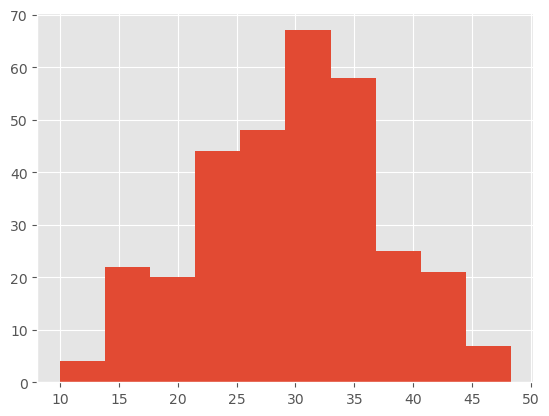

In [133]:
soybean_df.YIELD.hist()

Text(0.5, 1.0, 'Correlation Matrix')

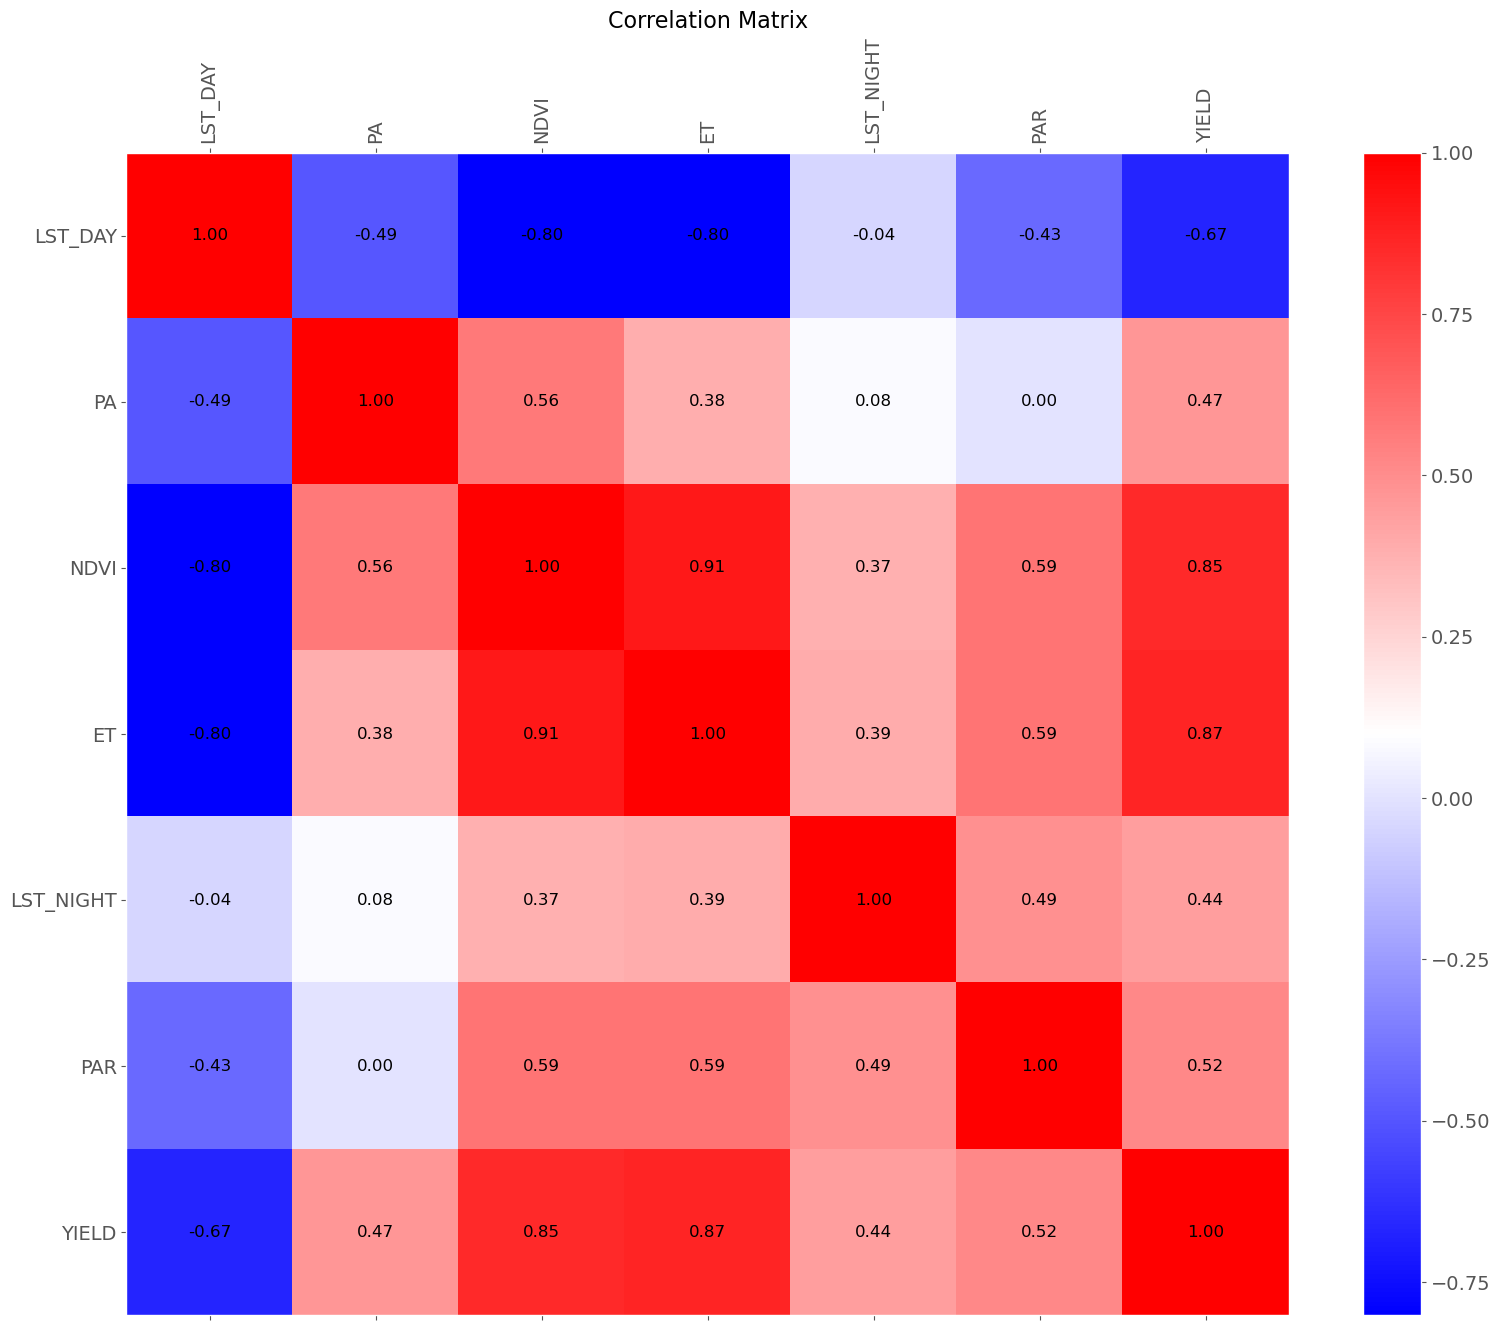

In [134]:
# Correlation coefficients
correlation_matrix = soybean_df.corr()

plt.rcParams["axes.grid"] = False
f = plt.figure(figsize=(19, 15))
plt.matshow(soybean_df.corr(), fignum=f.number,cmap='bwr')
plt.xticks(range(soybean_df.shape[1]), soybean_df.columns, fontsize=14, rotation=90)
plt.yticks(range(soybean_df.shape[1]), soybean_df.columns, fontsize=14)

for i in range(soybean_df.shape[1]):
    for j in range(soybean_df.shape[1]):
        plt.text(j, i, f'{correlation_matrix.iloc[i, j]:.2f}', ha='center', va='center', fontsize=12, color='black')

cb = plt.colorbar()
cb.ax.tick_params(labelsize=14)

plt.savefig('correlation_matrix_soybean.png', bbox_inches='tight')

plt.title('Correlation Matrix', fontsize=16)

## 2.1 Train & Test Data Split

In [135]:
#split the dataset
X = soybean_df.drop('YIELD', axis=1)
y = soybean_df['YIELD']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=100)

## 2.2 Train & Test Data Standarderlized

In [136]:
def standardize_columns(file_name, columns_to_standardize):
    scaler = StandardScaler()

    df = file_name
    df[columns_to_standardize] = scaler.fit_transform(df[columns_to_standardize])
    return df

def standardize_series(series):
    scaler = StandardScaler()
    series = scaler.fit_transform(series.values.reshape(-1, 1)).flatten()
    return series
    
X_columns = ['LST_DAY','PA','NDVI','ET','LST_NIGHT','PAR']
y_columns = ['YIELD']

X_train = standardize_columns(X_train, X_columns)
X_test = standardize_columns(X_test, X_columns)

#y_train = standardize_series(y_train)
#y_test = standardize_series(y_test)


## 3. Model Training and Parameter Tuning

### 3.1. Linear Regression (LR)

In [137]:
model_lr = LinearRegression()

# Cross validation
scores = cross_val_score(model_lr, X, y, cv=5, scoring='neg_mean_squared_error')

mean_mse = np.mean(scores)
std_mse = np.std(scores)

print(f'Mean MSE: {mean_mse}')
print(f'Standard Deviation of MSE: {std_mse}')

Mean MSE: -13.599376472183371
Standard Deviation of MSE: 1.42475853144851


In [138]:
model_lr.fit(X_train, y_train)

LinearRegression()

### 3.2. Random Forest Regressor (RF)

In [139]:
# values of max_depth and min_samples_split
hyperparameters = {'max_depth':[3,5,10,20,30], 'min_samples_split':[2,4,6,8,10]}


randomState_dt = 10000
model_rf = RandomForestRegressor(random_state=randomState_dt)

# cv=5 by default, which means 5-fold cross-validation
clf = GridSearchCV(model_rf, hyperparameters)

clf.fit(X_train, y_train)

# we can query the best parameter value and its accuracy score
print ("The best parameter value is: ")
print (clf.best_params_)
print ("The best score is: ")
print (clf.best_score_)

The best parameter value is: 
{'max_depth': 20, 'min_samples_split': 4}
The best score is: 
0.8122505039988435


In [140]:
# Train the final RF
rf_final = RandomForestRegressor(max_depth=clf.best_params_['max_depth'], min_samples_split=clf.best_params_['min_samples_split'], random_state=randomState_dt)
rf_final.fit(X_train, y_train)

RandomForestRegressor(max_depth=20, min_samples_split=4, random_state=10000)

### 3.3. Gradient Boosting Regressor (XGB)

In [141]:
import warnings

# 设置忽略 FutureWarning 类型的警告
warnings.simplefilter(action='ignore', category=FutureWarning)

In [142]:
# model_xgb =
# soybean_df

# values of max_depth and min_samples_split
hyperparameters = {'max_depth':[2,4,6,8,10], 'n_estimators':[4,8,12,16,20]}

randomState_xgb = 125
xgb = XGBRegressor(random_state=randomState_xgb)

# cv=5 by default, which means 5-fold cross-validation
gscv_xgb = GridSearchCV(xgb, hyperparameters)

gscv_xgb.fit(X_train, y_train)

# we can query the best parameter value and its accuracy score
print ("The best parameter value is: ")
print (gscv_xgb.best_params_)
print ("The best score is: ")
print (gscv_xgb.best_score_)

The best parameter value is: 
{'max_depth': 2, 'n_estimators': 20}
The best score is: 
0.8119468473201896


### 3.4. Artificial Neural Network (ANN)

In [145]:
model_ann = keras.Sequential([
    layers.Input(shape=(6,)),  # Input layer
    layers.Dense(128, activation='relu'),  # Hidden layer with ReLU activation
    layers.Dropout(0.5),  # Dropout layer for regularization
    layers.Dense(64, activation='relu'),  # Additional hidden layer
    layers.Dropout(0.3),  # Another dropout layer
    layers.Dense(1)  # Output layer
])

#measuring the training with certain metrics
model_ann.compile(optimizer='adam', loss='mean_squared_error', metrics=['accuracy'])

In [146]:
#train the model
model_ann.fit(X_train, y_train, epochs=100, validation_data=(X_test, y_test))

Epoch 1/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - accuracy: 0.0000e+00 - loss: 908.8058 - val_accuracy: 0.0000e+00 - val_loss: 874.9622
Epoch 2/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.0000e+00 - loss: 881.8877 - val_accuracy: 0.0000e+00 - val_loss: 824.8320
Epoch 3/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.0000e+00 - loss: 807.2585 - val_accuracy: 0.0000e+00 - val_loss: 761.8193
Epoch 4/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.0000e+00 - loss: 770.3871 - val_accuracy: 0.0000e+00 - val_loss: 682.5032
Epoch 5/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.0000e+00 - loss: 673.8093 - val_accuracy: 0.0000e+00 - val_loss: 588.1645
Epoch 6/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.0000e+00 - loss: 548.4451 - val_accuracy: 0.0000e+00 - val_loss: 482.6881
Epoch 7/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.0000e+00 - loss: 474.4578 - val_accuracy: 0.0000e+00 - val_loss: 372.2153
Epoch 8/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 

## 4. Model Evaluation and Performance Comparison

Comparing the performance with using R2 and Root Mean Squared Error (RMSE).

### 4.1. E. Linear Regression (LR)

In [147]:
train_predictions = model_lr.predict(X_train)
test_predictions = model_lr.predict(X_test)

r2_train_lr = r2_score(y_train, train_predictions)
r2_test_lr = r2_score(y_test, test_predictions)

rmse_train_lr = mean_squared_error(y_train, train_predictions, squared=False)
rmse_test_lr = mean_squared_error(y_test, test_predictions, squared=False)

print(f"Training R^2: {r2_train_lr:.4f}")
print(f"Test R^2: {r2_test_lr:.4f}")
print(f"Training RMSE: {rmse_train_lr:.4f}")
print(f"Test RMSE: {rmse_test_lr:.4f}")

Training R^2: 0.7965
Test R^2: 0.7977
Training RMSE: 3.4311
Test RMSE: 3.5609


### 4.2. E. Random Forest Regressor (RF)

In [148]:
r2_train_rf = rf_final.score(X=X_train, y=y_train)
r2_test_rf = rf_final.score(X=X_test, y=y_test)

print("R2 on the training data:")
print(r2_train_rf)
print("R2 on the testing data:")
print(r2_test_rf)

R2 on the training data:
0.9688517783796329
R2 on the testing data:
0.8370134081603526


In [149]:
rmse_train_rf = mean_squared_error(y_train, rf_final.predict(X_train), squared=False)
rmse_test_rf = mean_squared_error(y_test, rf_final.predict(X_test), squared=False)

print("RMSE on the training data:")
print(rmse_train_rf)
print("RMSE on the testing data:")
print(rmse_test_rf)

RMSE on the training data:
1.3425104723153702
RMSE on the testing data:
3.196618497059926


                                        Importance
Feature                                           
NDVI                                        0.4985
ET                                          0.3073
PA                                          0.0500
LST_DAY                                     0.0366
LST_NIGHT                                   0.0193
PAR                                         0.0123


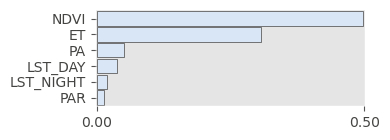

In [150]:
# Calculate and plot the feature importance of the RF model
imp = rfpimp.importances(rf_final, X_test, y_test)
print(imp)
viz = rfpimp.plot_importances(imp)
viz.view()

### 4.3. E. Gradient Boosting Regressor (XGB)

In [151]:
model_xgb = XGBRegressor(max_depth=gscv_xgb.best_params_['max_depth'], n_estimators=gscv_xgb.best_params_['n_estimators'], random_state=randomState_xgb)
model_xgb.fit(X_train, y_train)


XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=2, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=20, n_jobs=None,
             num_parallel_tree=None, random_state=125, ...)

In [152]:
# r2_train_xgb, r2_test_xgb, rmse_train_xgb, rmse_test_xgb
r2_train_xgb = model_xgb.score(X=X_train, y=y_train)
r2_test_xgb = model_xgb.score(X=X_test, y=y_test)
rmse_train_xgb = mean_squared_error(y_train, model_xgb.predict(X_train), squared=False)
rmse_test_xgb = mean_squared_error(y_test, model_xgb.predict(X_test), squared=False)

In [153]:
print("R2 on the training data:")
print(r2_train_xgb)
print("R2 on the testing data:")
print(r2_test_xgb)

R2 on the training data:
0.9100252787798567
R2 on the testing data:
0.8426691231672218


In [154]:
print("RMSE on the training data:")
print(rmse_train_xgb)
print("RMSE on the testing data:")
print(rmse_test_xgb)

RMSE on the training data:
2.281714534929037
RMSE on the testing data:
3.14066670480111


                                        Importance
Feature                                           
NDVI                                        0.4580
ET                                          0.3588
LST_NIGHT                                   0.0464
PA                                          0.0407
LST_DAY                                     0.0358
PAR                                         0.0213


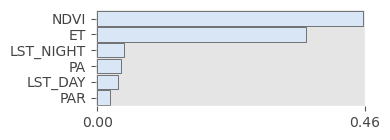

In [155]:
imp_xgb = rfpimp.importances(model_xgb, X_test, y_test) # permutation
print(imp_xgb)
viz_xgb = rfpimp.plot_importances(imp_xgb)
viz_xgb.view()

### 4.4. E. Artificial Neural Network (ANN)

In [156]:
#predictions
y_pred_train_ann = model_ann.predict(X_train).flatten()
y_pred_test_ann = model_ann.predict(X_test).flatten()

#Compute R2 and RMSE
r2_train_ann = np.round(r2_score(y_train, y_pred_train_ann),2)
r2_test_ann = np.round(r2_score(y_test, y_pred_test_ann),2)
rmse_train_ann = np.round(np.sqrt(mean_squared_error(y_train, y_pred_train_ann)),2)
rmse_test_ann = np.round(np.sqrt(mean_squared_error(y_test, y_pred_test_ann)),2)

#print the result
print("Train R2:", r2_train_ann)
print("Test R2:", r2_test_ann)
print("Train RMSE:", rmse_train_ann)
print("Test RMSE:", rmse_test_ann)

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
Train R2: 0.82
Test R2: 0.8
Train RMSE: 3.2
Test RMSE: 3.55


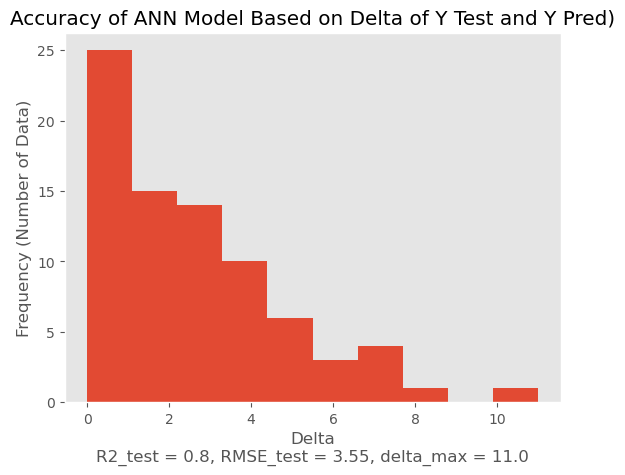

In [157]:
#crosscheck the y value between real and predicted
crosscheck_y_dict = {
    'y_test' : y_test,
    'y_pred' : np.round(y_pred_test_ann,0),
    'delta' : np.abs(np.round((y_test - y_pred_test_ann),0))
}

#plotting histogram
crosscheck_y_df = pd.DataFrame(crosscheck_y_dict)
plt.hist(crosscheck_y_df['delta'], bins=10)
plt.xlabel(f'Delta\nR2_test = {r2_test_ann}, RMSE_test = {rmse_test_ann}, delta_max = {crosscheck_y_df.delta.max()}')
plt.ylabel('Frequency (Number of Data)')
plt.title(f"Accuracy of ANN Model Based on Delta of Y Test and Y Pred)")
plt.show()

### 4.5. Model Performance Comparison

In [158]:
#please input your metrics in here
metrics_dict = {
    'metrics': ["Train R2","Test R2","Train RMSE","Test RMSE"],
    'LR': [r2_train_lr, r2_test_lr, rmse_train_lr, rmse_test_lr],
    'RF': [r2_train_rf, r2_test_rf, rmse_train_rf, rmse_test_rf],
    'XGB': [r2_train_xgb, r2_test_xgb, rmse_train_xgb, rmse_test_xgb],
    'ANN': [r2_train_ann, r2_test_ann, rmse_train_ann, rmse_test_ann]
}

#create dataframe
metrics_df = pd.DataFrame(metrics_dict)
metrics_df.set_index('metrics')

,LR,RF,XGB,ANN
metrics,,,,
Train R2,0.7965,0.9689,0.9100,0.8200
Test R2,0.7977,0.8370,0.8427,0.8000
Train RMSE,3.4311,1.3425,2.2817,3.2000
Test RMSE,3.5609,3.1966,3.1407,3.5500


Based on the comparison, it can be said that the best model that can be used for estimating crop yield is []. From this point, [] model would be used for estimation phase (step 5).

## 5. Crop Yield Estimation and Export Result